# COURSE: A deep understanding of deep learning
## SECTION: Overfitting, cross-validation, regularization
### LECTURE: Cross-validation -- scikitlearn
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Susukkekki/DeepUnderstandingOfDeepLearning/blob/main/overfitting/DUDL_overfitting_scikitlearn.ipynb)

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# NEW!
from sklearn.model_selection import train_test_split

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# A brief aside on using train_test_split

In [3]:
# create our fake dataset

fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = \
                        train_test_split(fakedata, fakelabels, test_size=.2)

# NOTE the third input parameter above.
# This can be specified as test size or training size.
# Be mindful of which parameter is written!



# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

# print out the train/test data
print('Training data: ')
print(train_data)
print(' ')

print('Test data: ')
print(test_data)

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[ 71  72  73  74]
 [ 21  22  23  24]
 [101 102 103 104]
 [ 41  42  43  44]
 [ 11  12  13  14]
 [ 31  32  33  34]
 [ 91  92  93  94]
 [ 81  82  83  84]]
 
Test data: 
[[51 52 53 54]
 [61 62 63 64]]


# Now back to the model

In [5]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [12]:
# train the model

# global parameter
numepochs = 200

def trainTheModel(trainProp):

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp)

  # loop over epochs
  for epochi in range(numepochs):

    # separate train from test data
    # Note 1: unique split for each epoch!
    # Note 2: here we specify the training size, not the testing size!
    # This would be overfitting
    # X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp)


    # forward pass and loss
    yHat = ANNiris(X_train)
    loss = lossfun(yHat,y_train)
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute training accuracy
    trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )
    
    # test accuracy
    predlabels = torch.argmax( ANNiris(X_test),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )
  
  # function output
  return trainAcc,testAcc


# Test the model by running it once

In [13]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
trainAcc,testAcc = trainTheModel(.8)


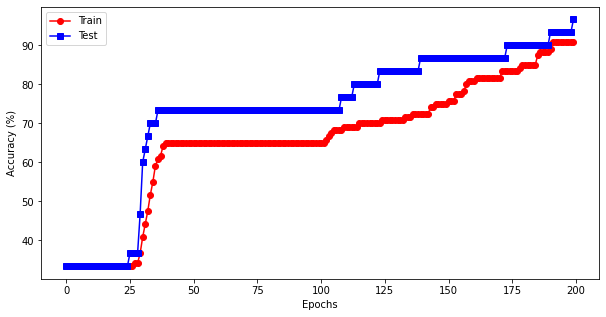

In [14]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

# Now for the experiment

In [15]:
trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):
  
  # create a model
  ANNiris,lossfun,optimizer = createANewModel()
  
  # train the model
  trainAcc,testAcc = trainTheModel(trainSetSizes[i])
  
  # store the results
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

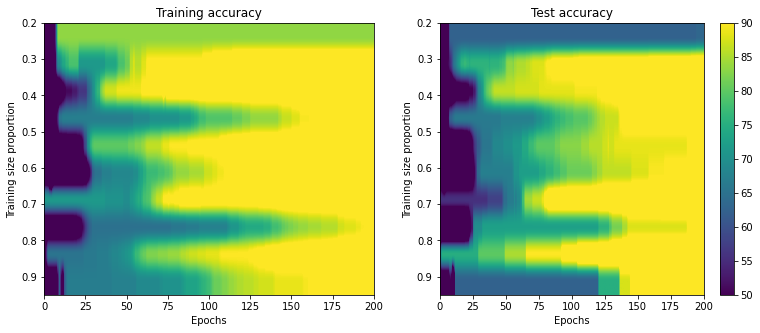

In [16]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

# Additional explorations

In [ ]:
# 1) The images above suggest that the training proportion doesn't really affect learning success (for this data and this
#    model). Does increasing the number of epochs to 1000 change the conclusion? How about with a lr=.001?
# 
# 2) According to the help doc for train_test_split(), the train_size input can be either a float between 0.0 and 1.0, or
#    an int. Here we only used float inputs to indicate the proportion of the data used for training. Modify the code to
#    specify the training size as an integer corresponding to the number of samples.
# 